In [212]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

In [213]:
%%writefile rock_agent.py

#always rock
def rock(observation, configuration):
    return 0

Overwriting rock_agent.py


In [214]:
%%writefile paper_agent.py

#always paper
def paper(observation, configuration):
    return 1

Overwriting paper_agent.py


In [215]:
%%writefile scissors_agent.py

#always scissors
def scissors(observation, configuration):
    return 2

Overwriting scissors_agent.py


In [216]:
%%writefile copy_opponent.py
import random

#copies last oppenent's action
def copy_opponent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

Overwriting copy_opponent.py


In [217]:
%%writefile reactionary.py
import random

last_react_action = None

def get_score(a, b):
    if a == b: return 0
    if a < b: return -1
    else: return 1

#checks reaction for last opponent's action
def reactionary(observation, configuration):
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

Overwriting reactionary.py


In [218]:
%%writefile counter_reactionary.py
import random

last_counter_action = None

def get_score(a, b):
    if a == b: return 0
    if a < b: return -1
    else: return 1

#counter strategy for reactionary
def counter_reactionary(observation, configuration):
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action

Overwriting counter_reactionary.py


In [219]:
%%writefile statistical.py

action_histogram = {}

#checks statistics of opponent's actions
def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting statistical.py


In [220]:
%%writefile rock_paper.py
import random

#rock or paper
def rock_paper(observation, configuration):
    return random.randrange(2)

Overwriting rock_paper.py


In [238]:
%%writefile random_agent.py
import random

#random sing
def random_agent(observation, configuration):
    return random.randrange(3)

Overwriting random_agent.py


In [222]:
%%writefile most_frequent.py
import random
steps = []

#reaction to most frequent opponent's action
def most_frequent(observation, configuration):
    global opponent_steps
    
    if len(steps) == 0:
        steps.append(random.randrange(3))
    else:
        steps.append(observation["lastOpponentAction"])
    
    most_freq = max(set(steps), key=steps.count)
    
    if most_freq == 0 : return 1
    elif most_freq == 1: return 2
    else: return 0
    

Overwriting most_frequent.py


In [223]:
%%writefile simple_method.py
import random

recs = []

def simple_method(observation, configuration):
    global recs
    
    count=len(recs)
    
    if count==0:
        hand = random.randint(0, 2)
        
    else:
        recs.append(observation["lastOpponentAction"])

        hand_count = [recs.count(0), recs.count(1), recs.count(2)]
        hand_ratio = [hand_count[0], hand_count[0] + hand_count[1], count] / count

        hand_rand = random.random()
        for i,ratio in enumerate(hand_ratio):
            if hand_rand <= ratio:
                hand = i
                break
    
    return (hand + 1) % 3

Overwriting simple_method.py


In [224]:
%%writefile anti_statistical.py

action_histogram = {}
my_last_action = 1

#counter strategy for statistical
def anti_statistical(observation, configuration):
    global action_histogram
    global my_last_action            
    
    if observation.step == 0:
        action_histogram = {}
        return 1
    
    action = my_last_action
    
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue
            
    my_action = (mode_action - 1) % configuration.signs
    
    my_last_action = my_action 

    return my_action

Overwriting anti_statistical.py


In [240]:
list_names = [
    "rock_agent", 
    "paper_agent", 
    "scissors_agent",
    "copy_opponent",   
    "reactionary", 
    "counter_reactionary", 
    "statistical", 
    "rock_paper",
    "random_agent",
    "most_frequent",
    "simple_method",
    "anti_statistical"
]

list_agents = [agent_name + ".py" for agent_name in list_names]

n_agents = len(list_names)

scores = np.zeros((n_agents, n_agents), dtype=int)

In [241]:
#processing tournament
print("Simulation of battles. It can take some time...")
count = 0
for ind_agent_1 in range(len(list_names)):
    count += 1
    for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
        
        
        current_score = evaluate(
            "rps", 
            [list_agents[ind_agent_1], list_agents[ind_agent_2]], 
            configuration={"episodeSteps": 100}
        )
        
        scores[ind_agent_1, ind_agent_2] = current_score[0][0]
        scores[ind_agent_2, ind_agent_1] = current_score[0][1]

        print(
                f"Process: {((count / (len(list_names))) * 100):.2f} %", 
                end="\r"
            )
print("Simulation completed")

Simulation of battles. It can take some time...
Simulation completed


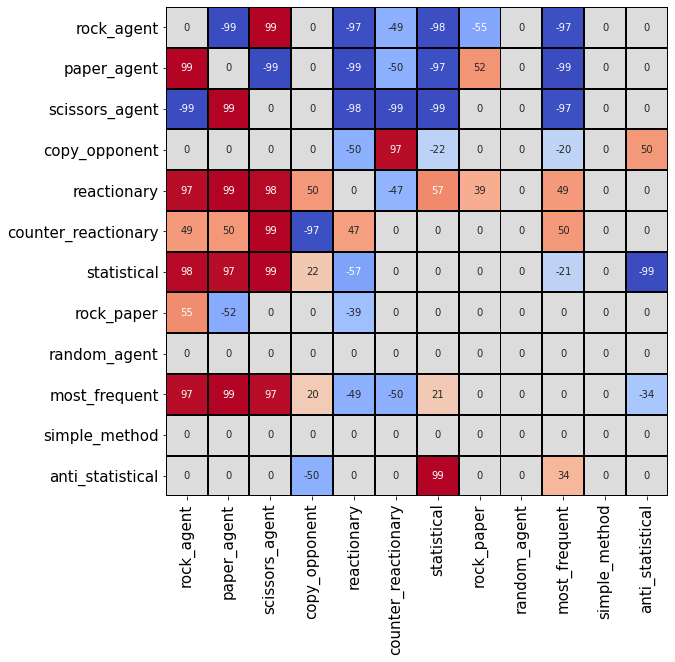

In [242]:
#scores heatmap
df_scores = pd.DataFrame(
    scores, 
    index=list_names, 
    columns=list_names,
)


plt.figure(figsize=(9, 9))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap='coolwarm', linewidths=1, 
    linecolor='black', fmt="d",
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);

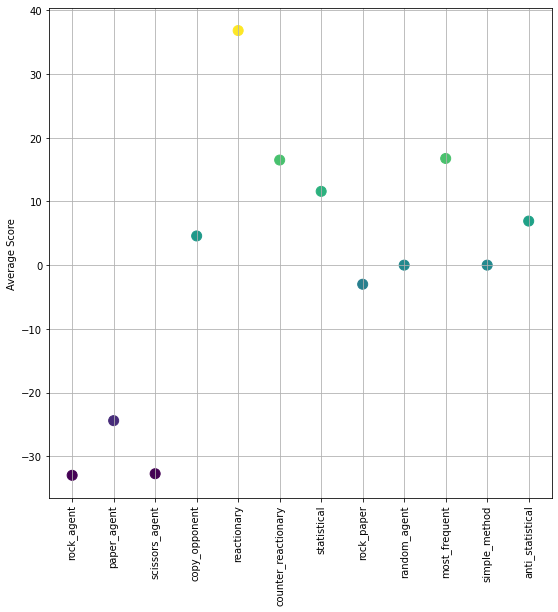

In [312]:
#average score for each strategy
x = [i for i in range(len(list_names))]
plt.figure(figsize=(9, 9))
plt.scatter(x, average_scores, s=100, c=average_scores)
plt.xticks(x, list_names, rotation='vertical')
plt.ylabel("Average Score")
plt.grid(True)
plt.show()

#reactionary is the best according to average winning score